In [1]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip uninstall -y pretrainedmodels
!pip uninstall -y efficientnet-pytorch
!pip uninstall -y timm
!pip uninstall -y segmentation-models-pytorch

Found existing installation: pretrainedmodels 0.7.4
Uninstalling pretrainedmodels-0.7.4:
  Successfully uninstalled pretrainedmodels-0.7.4
Found existing installation: efficientnet-pytorch 0.7.1
Uninstalling efficientnet-pytorch-0.7.1:
  Successfully uninstalled efficientnet-pytorch-0.7.1
Found existing installation: timm 0.9.12
Uninstalling timm-0.9.12:
  Successfully uninstalled timm-0.9.12
Found existing installation: segmentation-models-pytorch 0.3.3
Uninstalling segmentation-models-pytorch-0.3.3:
  Successfully uninstalled segmentation-models-pytorch-0.3.3


In [3]:
# https://github.com/qubvel/segmentation_models.pytorch/issues/11
# !pip install -U pretrainedmodels==0.7.4 --user
# !pip install -U efficientnet-pytorch==0.7.1 --user

# !pip install -U timm --user # !pip install -U timm==0.9.2 --user

In [4]:
# Install required libs
# !pip install -U git+https://github.com/qubvel/segmentation_models.pytorch

In [5]:
%%writefile requirements.txt
torchvision>=0.5.0
pretrainedmodels==0.7.4
efficientnet-pytorch==0.7.1
#timm==0.9.7
timm
tqdm
pillow
six

Overwriting requirements.txt


In [6]:
!pip install -r requirements.txt

  Using cached pretrainedmodels-0.7.4-py3-none-any.whl
  Using cached efficientnet_pytorch-0.7.1-py3-none-any.whl


In [7]:
# Install required libs
!pip install -U segmentation-models-pytorch albumentations --user

  Using cached segmentation_models_pytorch-0.3.3-py3-none-any.whl (106 kB)


In [8]:
#!pip uninstall -y segmentation-models-pytorch

## Loading data

In [9]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt

In [10]:
# helper function for data visualization
def visualize(**images):
    """Plot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [11]:
######################################################################
######################################################################
DATA_DIR = '/content/drive/MyDrive/ai_ind_cv/projects/p3/dataset/'

x_train_dir = os.path.join(DATA_DIR, 'images_prepped_train')
y_train_dir = os.path.join(DATA_DIR, 'annotations_prepped_train')

x_test_dir = os.path.join(DATA_DIR, 'images_prepped_test')
y_test_dir = os.path.join(DATA_DIR, 'annotations_prepped_test')
######################################################################
######################################################################

### Dataloader

In [12]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [13]:
class Dataset(BaseDataset):
    CLASSES = ['sky', 'building', 'pole', 'road', 'pavement',
               'tree', 'signsymbol', 'fence', 'car',
               'pedestrian', 'bicyclist', 'unlabeled']

    def __init__(
            self,
            images_dir,
            masks_dir,
            classes=None,
            augmentation=None,
            preprocessing=None,
    ):
        ids_all = os.listdir(images_dir) # list file gambar awal
        mask_all = os.listdir(masks_dir) # list file mask
        np_ids_all = np.asarray(ids_all) # biar konversinya mudah, dtype 'list' diubah menjadi dtype numpy array
        np_ids_all = np_ids_all[np.isin(np_ids_all, mask_all)] # memfilter data image yang hanya memiliki data mask

        self.ids =np_ids_all.tolist() # self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]

        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]

        self.augmentation = augmentation
        self.preprocessing = preprocessing


    def __getitem__(self, i):

        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)

        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        return len(self.ids)

### Showing Data

In [14]:
dataset = Dataset(
    x_train_dir,
    y_train_dir,
    classes = ['sky', 'building', 'pole', 'road', 'pavement',
               'tree', 'signsymbol', 'fence', 'car',
               'pedestrian', 'bicyclist', 'unlabeled'])

image:61


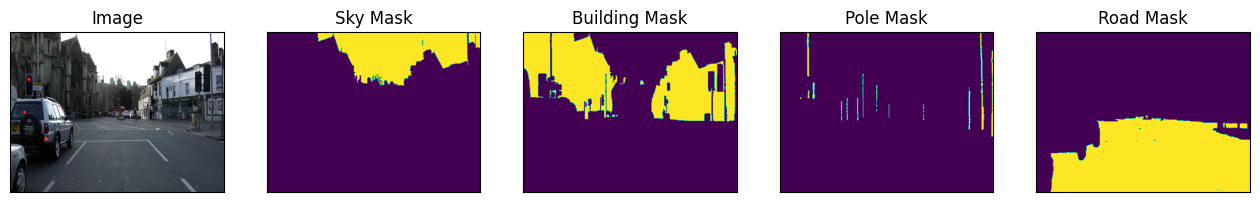

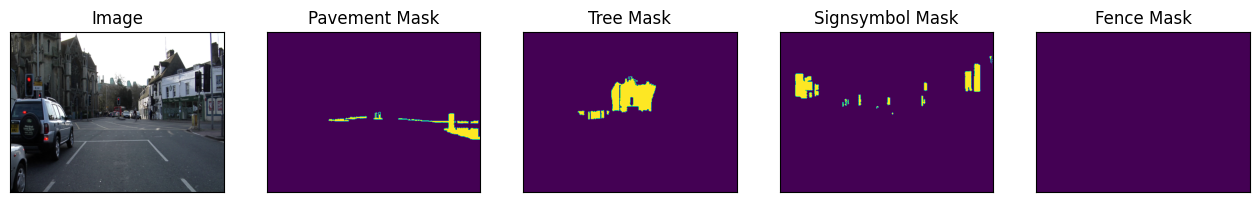

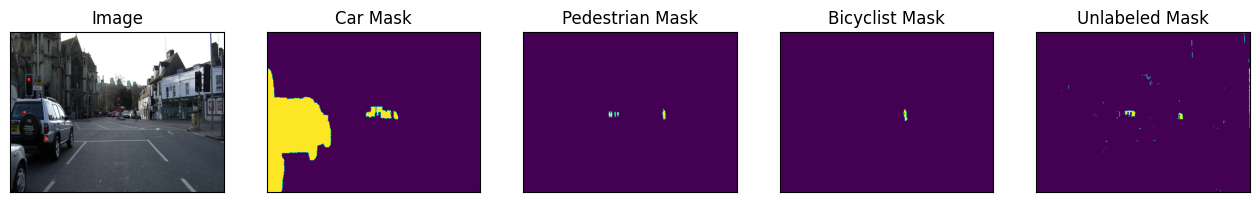

In [15]:
show_id = np.random.randint(0, len(dataset))
image, mask = dataset[show_id]

print(f'image:{show_id}')

visualize(
    image=image,
    sky_mask=mask[..., 0].squeeze(),
    building_mask=mask[..., 1].squeeze(),
    pole_mask=mask[..., 2].squeeze(),
    road_mask=mask[..., 3].squeeze(),
)

visualize(
    image=image,
    pavement_mask=mask[..., 4].squeeze(),
    tree_mask=mask[..., 5].squeeze(),
    signsymbol_mask=mask[..., 6].squeeze(),
    fence_mask=mask[..., 7].squeeze(),
)

visualize(
    image=image,
    car_mask=mask[..., 8].squeeze(),
    pedestrian_mask=mask[..., 9].squeeze(),
    bicyclist_mask=mask[..., 10].squeeze(),
    unlabeled_mask=mask[..., 11].squeeze(),
)

image:226


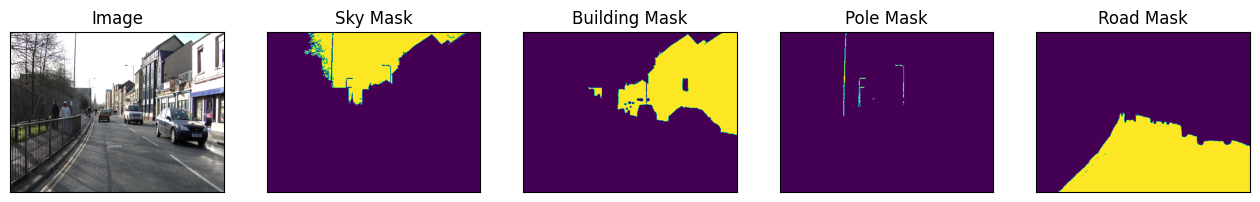

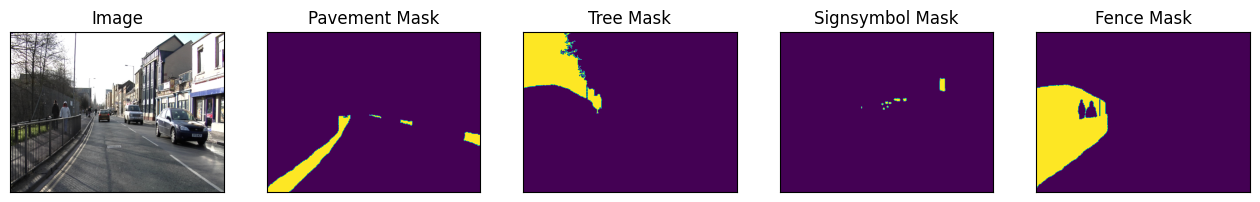

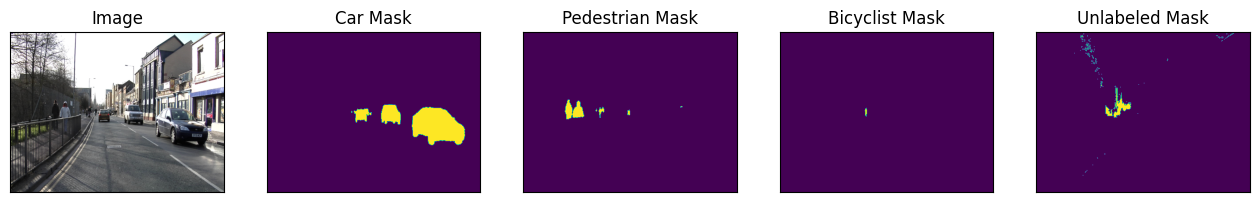

In [16]:
show_id2 = 226 # np.random.randint(len(dataset))
image, mask = dataset[show_id2]

print(f'image:{show_id2}')

visualize(
    image=image,
    sky_mask=mask[..., 0].squeeze(),
    building_mask=mask[..., 1].squeeze(),
    pole_mask=mask[..., 2].squeeze(),
    road_mask=mask[..., 3].squeeze(),
)

visualize(
    image=image,
    pavement_mask=mask[..., 4].squeeze(),
    tree_mask=mask[..., 5].squeeze(),
    signsymbol_mask=mask[..., 6].squeeze(),
    fence_mask=mask[..., 7].squeeze(),
)

visualize(
    image=image,
    car_mask=mask[..., 8].squeeze(),
    pedestrian_mask=mask[..., 9].squeeze(),
    bicyclist_mask=mask[..., 10].squeeze(),
    unlabeled_mask=mask[..., 11].squeeze(),
)

### Data Augmentations

In [17]:
import albumentations as albu

In [18]:
IMG_HEIGHT = 360
IMG_WIDTH = 480

IMG_HEIGHT_MIN = 352
IMG_HEIGHT_PAD = 384

def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),
        # albu.Resize(256, 256, p=1, always_apply=True),
        albu.Resize(IMG_HEIGHT_MIN, IMG_HEIGHT_MIN, p=1, always_apply=True),

        albu.PadIfNeeded(min_height=IMG_HEIGHT_MIN, min_width=IMG_HEIGHT_MIN, always_apply=True, border_mode=0),
        albu.RandomCrop(height=IMG_HEIGHT_MIN, width=IMG_HEIGHT_MIN, always_apply=True),

        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(IMG_HEIGHT_PAD, IMG_WIDTH)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform

    Args:
        preprocessing_fn (callbale): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose

    """

    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

/usr/local/lib/python3.10/dist-packages/albumentations/imgaug/transforms.py:261: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/usr/local/lib/python3.10/dist-packages/albumentations/imgaug/transforms.py:384: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/albumentations/imgaug/transforms.py:231: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/usr/local/lib/python3.10/dist-packages/alb

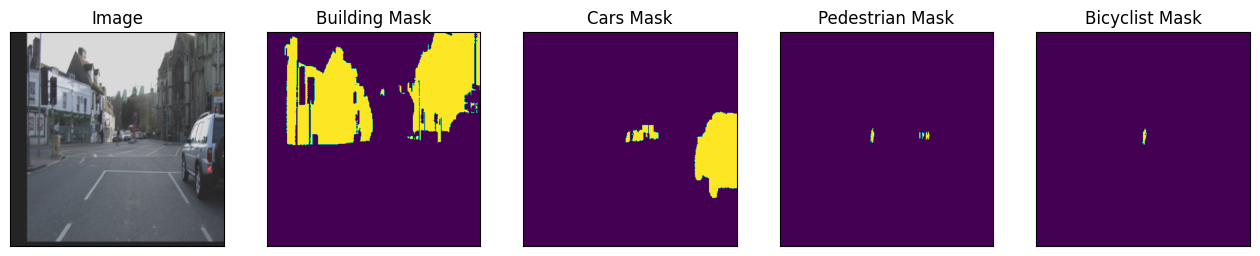

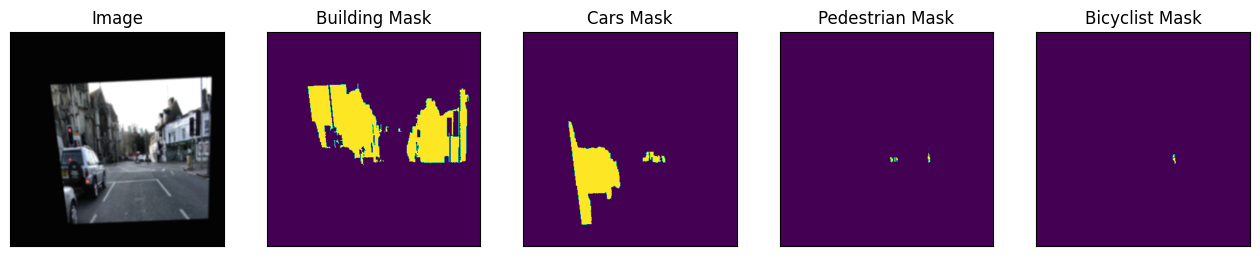

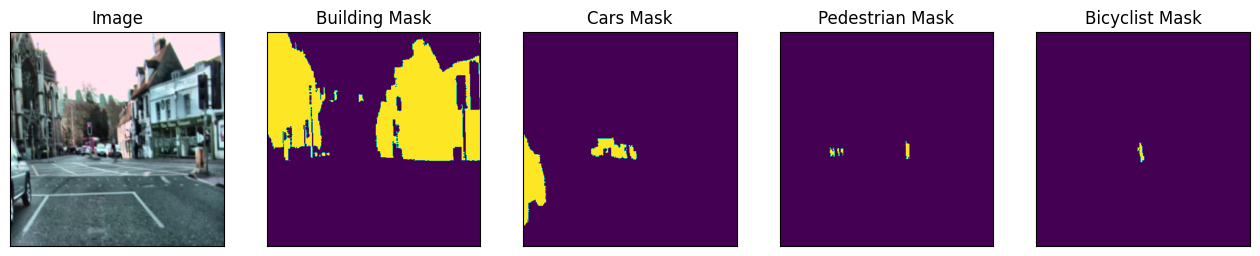

In [19]:
#### Visualize resulted augmented images and masks

augmented_dataset = Dataset(
    x_train_dir,
    y_train_dir,
    augmentation=get_training_augmentation(),
    classes=['sky', 'building', 'pole', 'road', 'pavement', 'tree', 'signsymbol', 'fence', 'car', 'pedestrian', 'bicyclist', 'unlabeled'],
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[show_id]
    visualize(
        image=image,
        building_mask=mask[..., 1].squeeze(),
        cars_mask=mask[..., 8].squeeze(),
        pedestrian_mask=mask[..., 9].squeeze(),
        bicyclist_mask=mask[..., 10].squeeze(),)

## Create model and train

In [20]:
!pip uninstall -y segmentation-models-pytorch

Found existing installation: segmentation-models-pytorch 0.3.3
Uninstalling segmentation-models-pytorch-0.3.3:
  Successfully uninstalled segmentation-models-pytorch-0.3.3


In [21]:
# !pip uninstall -y timm

In [22]:
!pip install -U timm --user

  Using cached timm-0.9.12-py3-none-any.whl (2.2 MB)


In [23]:
# !pip install -U pretrainedmodels==0.7.4 --user
# !pip install -U efficientnet-pytorch==0.7.1 --user

In [24]:
!pip install -U segmentation-models-pytorch

  Using cached segmentation_models_pytorch-0.3.3-py3-none-any.whl (106 kB)
  Using cached timm-0.9.2-py3-none-any.whl (2.2 MB)
  Attempting uninstall: timm
    Found existing installation: timm 0.9.12
    Uninstalling timm-0.9.12:
      Successfully uninstalled timm-0.9.12


In [25]:
import torch
import numpy as np
import segmentation_models_pytorch as smp # Masih sering error! Sepertinya library 'timm' tdk compatible
# belum nemu cara/penyebabnya.
# Untuk saat ini cara yg saya lakukan adalah menguninstall & install ulang libary requirementnya
# (saya jalankan lagi dari bagian 'Create model and train' di atas, langkah !pip uninstall -y segmentation-models-pytorch, dst)
# Dan biasanya akan muncul permintaan 'Restart Session' ... Maka saya restart dari awal. Setelah itu di bagian ini sdh tdk lg error

In [26]:
######################################################################
######################################################################
# ENCODER = efficientnet-b4'
# ENCODER = 'resnet50'
ENCODER = 'resnet101'

ENCODER_WEIGHTS = 'imagenet'
# ENCODER_WEIGHTS = None

# CLASSES = ['road']
CLASSES = ['sky', 'building', 'pole', 'road', 'pavement',
           'tree', 'signsymbol', 'fence', 'car',
           'pedestrian', 'bicyclist', 'unlabeled']

# ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
ACTIVATION = 'softmax2d'
######################################################################
######################################################################

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
)

######################################################################
######################################################################
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)
# preprocessing_fn = None
######################################################################
######################################################################

In [27]:
from torch.utils.data.sampler import SubsetRandomSampler

dataset = Dataset(
    x_train_dir,
    y_train_dir,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

######################################################################
######################################################################
train_batch_size = 8
validation_split = .2
shuffle_dataset = True
random_seed= 42
######################################################################
######################################################################

# Training and Validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(dataset, batch_size=train_batch_size, sampler=train_sampler)
valid_loader = DataLoader(dataset, batch_size=1, sampler=valid_sampler)


'''
train_dataset = Dataset(
    x_train_dir,
    y_train_dir,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir,
    y_valid_dir,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=12)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)
'''

/usr/local/lib/python3.10/dist-packages/albumentations/imgaug/transforms.py:261: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/usr/local/lib/python3.10/dist-packages/albumentations/imgaug/transforms.py:384: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/albumentations/imgaug/transforms.py:231: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/usr/local/lib/python3.10/dist-packages/alb

'\ntrain_dataset = Dataset(\n    x_train_dir,\n    y_train_dir,\n    augmentation=get_training_augmentation(),\n    preprocessing=get_preprocessing(preprocessing_fn),\n    classes=CLASSES,\n)\n\nvalid_dataset = Dataset(\n    x_valid_dir,\n    y_valid_dir,\n    augmentation=get_validation_augmentation(),\n    preprocessing=get_preprocessing(preprocessing_fn),\n    classes=CLASSES,\n)\n\ntrain_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=12)\nvalid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)\n'

In [28]:
# https://github.com/qubvel/segmentation_models.pytorch/issues/635
import segmentation_models_pytorch.utils.losses
import segmentation_models_pytorch.utils.metrics

######################################################################
######################################################################
LR = 0.0001
######################################################################
######################################################################

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
    smp.utils.metrics.Accuracy(),
    # smp.utils.metrics.Fscore()
]

optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=LR),
])

In [29]:
# create epoch runners
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

In [30]:
######################################################################
######################################################################
EPOCHS = 50
######################################################################
######################################################################

In [31]:
# set file name to best model
from datetime import datetime
import pytz

jkt_tz = pytz.timezone('Asia/Jakarta')
now_jkt = datetime.now(jkt_tz)
str_jkt = now_jkt.strftime("%y-%m-%d_%H.%M")
######################################################################
######################################################################
fname = f'p3_unet_qubvel_{ENCODER}_{ENCODER_WEIGHTS}_{EPOCHS}__' + str_jkt + '.pth'
######################################################################
######################################################################
print(fname)

p3_unet_qubvel_resnet101_imagenet_50__23-12-20_18.32.pth


In [32]:
# train model
_best_model = None
max_score = 0

x_epoch_data = []
train_dice_loss = []
train_acc_score = []
valid_dice_loss = []
valid_acc_score = []
train_iou_score = []
valid_iou_score = []

start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

start.record()

for i in range(0, EPOCHS):

    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)

    x_epoch_data.append(i)
    train_dice_loss.append(train_logs['dice_loss'])
    train_acc_score.append(train_logs['accuracy'])
    train_iou_score.append(train_logs['iou_score'])
    valid_dice_loss.append(valid_logs['dice_loss'])
    valid_acc_score.append(valid_logs['accuracy'])
    valid_iou_score.append(valid_logs['iou_score'])

    # if max_score < valid_logs['accuracy']:
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        # max_score = valid_logs['accuracy']
        torch.save(model, './' + fname)
        _best_model = model
        print('Model saved!')

    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')

end.record()

# Waits for everything to finish running
# torch.cuda.synchronize()

duration = start.elapsed_time(end) / 60000
print(f'Time elapsed: {duration} minutes')

# save .pth to drive
if _best_model is not None:
    os.makedirs('/content/drive/MyDrive/ai_ind_cv/projects/p3/results', exist_ok=True)
    BEST_MODEL_PATH = '/content/drive/MyDrive/ai_ind_cv/projects/p3/results/' + fname
    # torch.save(_best_model, BEST_MODEL_PATH)


Epoch: 0
valid: 100%|██████████| 73/73 [00:09<00:00,  7.65it/s, dice_loss - 0.6205, iou_score - 0.507, accuracy - 0.9672]
Model saved!

Epoch: 1
valid: 100%|██████████| 73/73 [00:10<00:00,  6.76it/s, dice_loss - 0.5195, iou_score - 0.6107, accuracy - 0.9724]
Model saved!

Epoch: 2
valid: 100%|██████████| 73/73 [00:10<00:00,  7.19it/s, dice_loss - 0.4468, iou_score - 0.6478, accuracy - 0.9723]
Model saved!

Epoch: 3
valid: 100%|██████████| 73/73 [00:10<00:00,  6.80it/s, dice_loss - 0.4072, iou_score - 0.6777, accuracy - 0.9761]
Model saved!

Epoch: 4
valid: 100%|██████████| 73/73 [00:10<00:00,  7.05it/s, dice_loss - 0.432, iou_score - 0.6835, accuracy - 0.9788]
Model saved!

Epoch: 5
valid: 100%|██████████| 73/73 [00:10<00:00,  6.96it/s, dice_loss - 0.366, iou_score - 0.6992, accuracy - 0.978]
Model saved!

Epoch: 6
valid: 100%|██████████| 73/73 [00:10<00:00,  7.25it/s, dice_loss - 0.3477, iou_score - 0.693, accuracy - 0.9765]

Epoch: 7
valid: 100%|██████████| 73/73 [00:09<00:00,  7.70

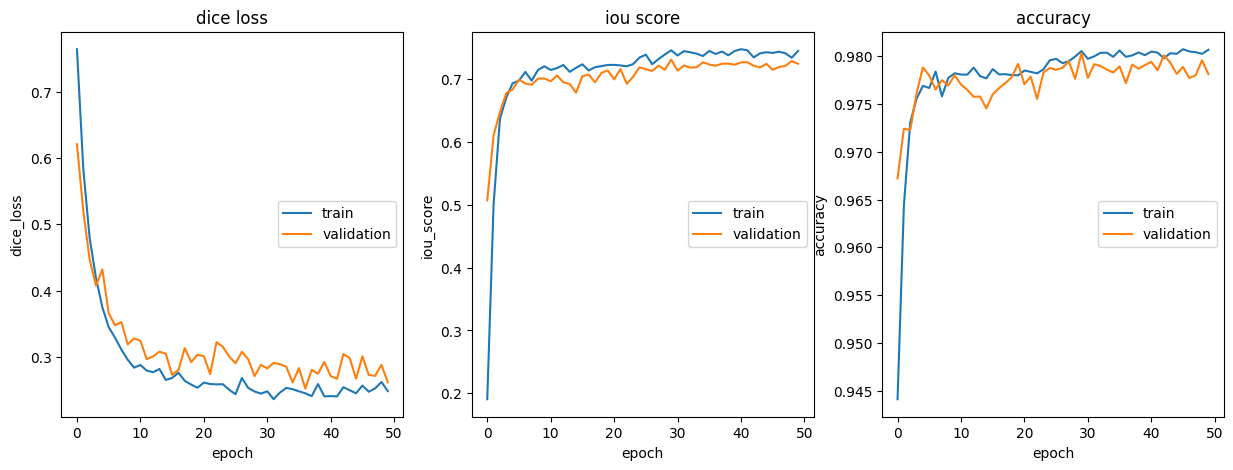

In [40]:
# https://colab.research.google.com/drive/1lsdBTtlEQXNFJPtpdtGmrw_RzMOaMH6u?usp=sharing#scrollTo=yGSdnoViIAOt
fig = plt.figure(figsize=(15, 5))

ax1 = fig.add_subplot(1, 3, 1)
line1, = ax1.plot(x_epoch_data,train_dice_loss,label='train')
line2, = ax1.plot(x_epoch_data,valid_dice_loss,label='validation')
ax1.set_title("dice loss")
ax1.set_xlabel('epoch')
ax1.set_ylabel('dice_loss')
ax1.legend(loc='center right')

ax1 = fig.add_subplot(1, 3, 2)
line1, = ax1.plot(x_epoch_data,train_iou_score,label='train')
line2, = ax1.plot(x_epoch_data,valid_iou_score,label='validation')
ax1.set_title("iou score")
ax1.set_xlabel('epoch')
ax1.set_ylabel('iou_score')
ax1.legend(loc='center right')

ax2 = fig.add_subplot(1, 3, 3)
line1, = ax2.plot(x_epoch_data,train_acc_score,label='train')
line2, = ax2.plot(x_epoch_data,valid_acc_score,label='validation')
ax2.set_title("accuracy")
ax2.set_xlabel('epoch')
ax2.set_ylabel('accuracy')
ax2.legend(loc='center right')

plt.show()

## Test best saved model

In [34]:
# load best saved checkpoint
best_model = torch.load('./' + fname)

In [35]:
# create test dataset
test_dataset = Dataset(
    x_test_dir,
    y_test_dir,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset)

In [36]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 101/101 [00:10<00:00, 10.08it/s, dice_loss - 0.1869, iou_score - 0.7299, accuracy - 0.9749]


## Visualize predictions

In [37]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    x_test_dir, y_test_dir,
    classes=CLASSES,
)

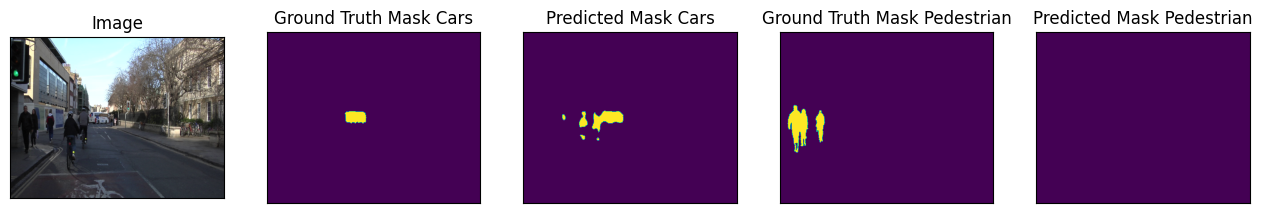

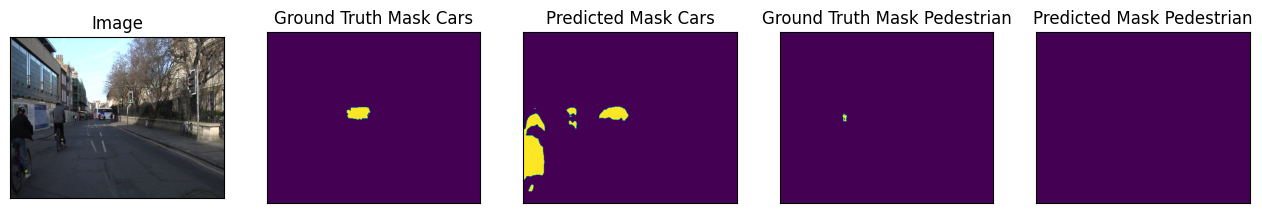

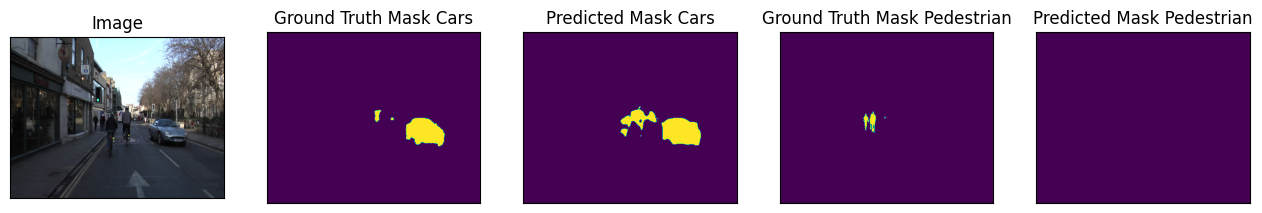

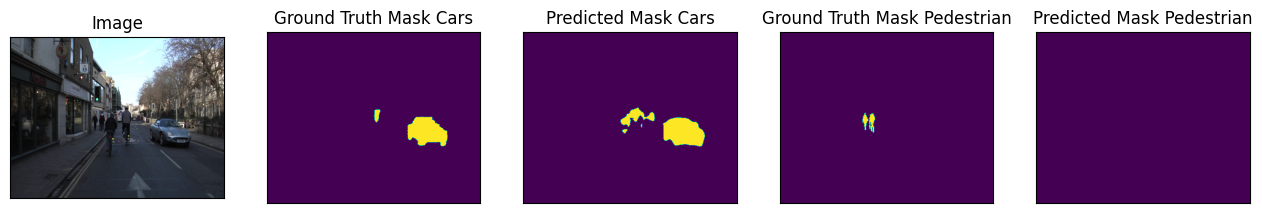

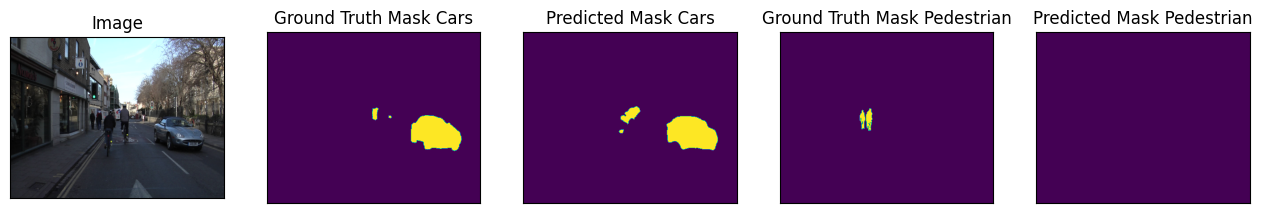

In [38]:
for i in range(5):
    n = np.random.choice(len(test_dataset))

    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]

    gt_mask = gt_mask.squeeze()

    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())

    visualize(
        image=image_vis,
        ground_truth_mask_cars=gt_mask[8],
        predicted_mask_cars=pr_mask[8],
        ground_truth_mask_pedestrian=gt_mask[9],
        predicted_mask_pedestrian=pr_mask[9],
    )

image:13


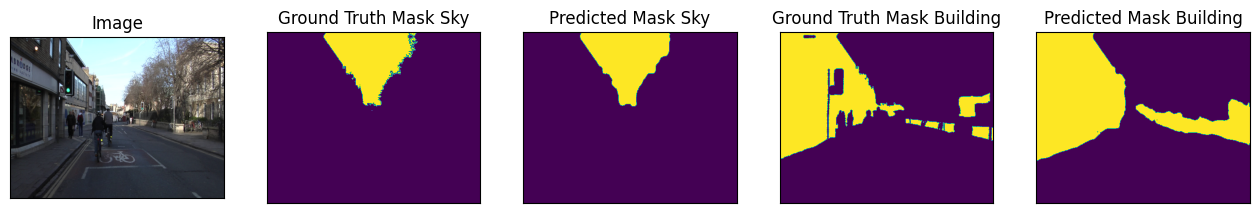

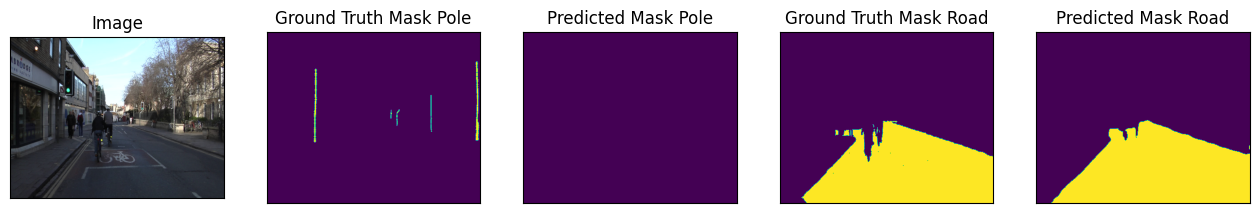

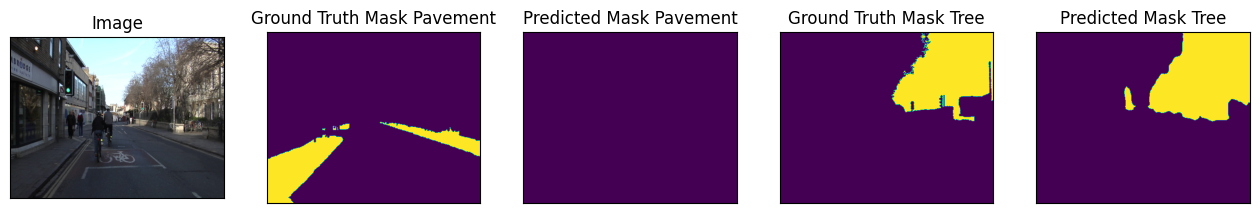

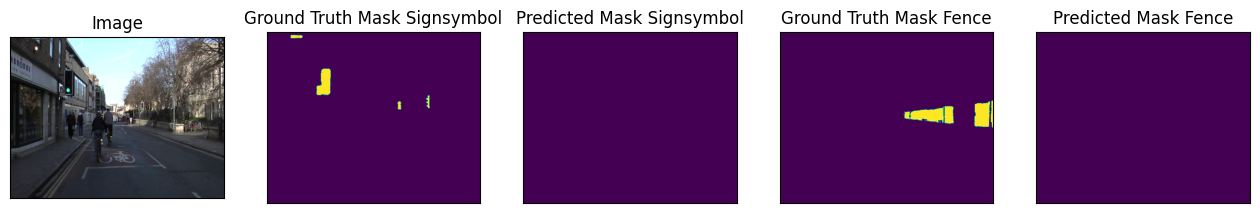

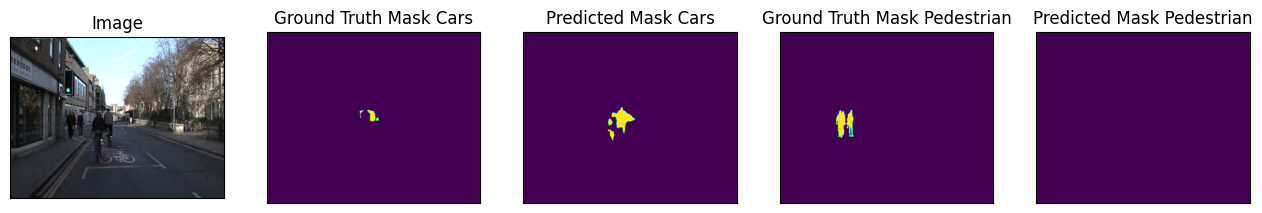

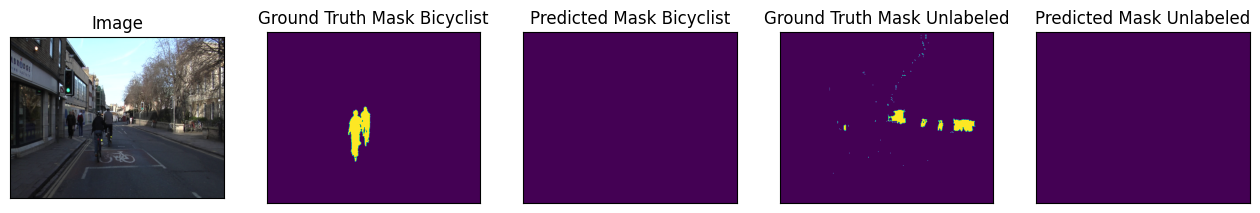

In [39]:
n = np.random.choice(len(test_dataset))

image_vis = test_dataset_vis[n][0].astype('uint8')
image, gt_mask = test_dataset[n]

gt_mask = gt_mask.squeeze()

x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
pr_mask = best_model.predict(x_tensor)
pr_mask = (pr_mask.squeeze().cpu().numpy().round())

print(f'image:{n}')

visualize(
    image=image_vis,
    ground_truth_mask_sky=gt_mask[0],
    predicted_mask_sky=pr_mask[0],
    ground_truth_mask_building=gt_mask[1],
    predicted_mask_building=pr_mask[1],
)
visualize(
    image=image_vis,
    ground_truth_mask_pole=gt_mask[2],
    predicted_mask_pole=pr_mask[2],
    ground_truth_mask_road=gt_mask[3],
    predicted_mask_road=pr_mask[3],
)
visualize(
    image=image_vis,
    ground_truth_mask_pavement=gt_mask[4],
    predicted_mask_pavement=pr_mask[4],
    ground_truth_mask_tree=gt_mask[5],
    predicted_mask_tree=pr_mask[5],
)
visualize(
    image=image_vis,
    ground_truth_mask_signsymbol=gt_mask[6],
    predicted_mask_signsymbol=pr_mask[6],
    ground_truth_mask_fence=gt_mask[7],
    predicted_mask_fence=pr_mask[7],
)
visualize(
    image=image_vis,
    ground_truth_mask_cars=gt_mask[8],
    predicted_mask_cars=pr_mask[8],
    ground_truth_mask_pedestrian=gt_mask[9],
    predicted_mask_pedestrian=pr_mask[9],
)
visualize(
    image=image_vis,
    ground_truth_mask_bicyclist=gt_mask[10],
    predicted_mask_bicyclist=pr_mask[10],
    ground_truth_mask_unlabeled=gt_mask[11],
    predicted_mask_unlabeled=pr_mask[11],
)